# Laboratorio 9 - Data Science
## Integrantes:
### Mario Guerra - 21008
### Javier Alvarado - 21188

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import re
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import unidecode
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import ace_tools_open as tools
#from transformers import pipeline

In [ ]:
# Descargar recursos de NLTK si no están disponibles
nltk.download('stopwords')
nltk.download('punkt_tab')

# Limpieza y Preprocesamiento de Datos

In [17]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

In [4]:
# Convertir texto a minúsculas.
df['rawContent'] = df['rawContent'].str.lower()

# Quitar URLs.
df['rawContent'] = df['rawContent'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar signos de puntuación dejando solamente @ y #.
df['rawContent'] = df['rawContent'].apply(lambda x: re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9@#\s]', '', x))

# Eliminar stopwords del conjunto de datos.
stop_words = set(stopwords.words('spanish'))

df['rawContent'] = df['rawContent'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [5]:
df = df.drop_duplicates(subset='id')
df['user_id'] = df['user'].apply(lambda x: x['id'])
df['username'] = df['user'].apply(lambda x: x['username'])
df['mentioned_users'] = df['mentionedUsers'].apply(lambda mentions: [user['username'] for user in mentions])
df['in_reply_to_user_id'] = df['inReplyToUser'].apply(lambda x: x['id'] if x else None)
df['retweeted_user_id'] = df['retweetedTweet'].apply(lambda x: x['user']['id'] if x else None)

In [6]:
# Estructura para las menciones.
mentions_df = df[['user_id', 'username', 'mentioned_users']].explode('mentioned_users')

# Renombrar las columnas para representarlas como aristas (usuario origen -> usuario destino)
mentions_df = mentions_df.rename(columns={'user_id': 'source_user', 'mentioned_users': 'target_user'})

# Estructura para las respuestas.
replies_df = df[['user_id', 'username', 'in_reply_to_user_id']].dropna()
# Renombrar las columnas para representarlas como aristas (usuario origen -> usuario destino)
replies_df = replies_df.rename(columns={'user_id': 'source_user', 'in_reply_to_user_id': 'target_user'})

# Estructura para los retweets.
retweets_df = df[['user_id', 'username', 'retweeted_user_id']].dropna()
# Renombrar las columnas para representarlas como aristas (usuario origen -> usuario destino)
retweets_df = retweets_df.rename(columns={'user_id': 'source_user', 'retweeted_user_id': 'target_user'})

In [7]:
# Concatenar todas las interacciones (menciones, respuestas y retweets).
edges_df = pd.concat([mentions_df, replies_df, retweets_df], ignore_index=True)

# Eliminar duplicados si es necesario.
edges_df = edges_df.drop_duplicates()

# Función para verificar si un valor es una cadena y no contiene solo números.
def is_valid_user(user):
    return isinstance(user, str) and not user.isdigit()

# Aplicar el filtro para eliminar interacciones no válidas.
edges_df = edges_df[edges_df['username'].apply(is_valid_user) & edges_df['target_user'].apply(is_valid_user)]

# Gráficos de visualización estáticos

In [8]:
# Extraer menciones de usuarios con @ en el contenido de los tweets
df['mentions'] = df['rawContent'].apply(lambda x: re.findall(r'@\w+', x))

# Contar las menciones más frecuentes
all_mentions = df['mentions'].explode().value_counts()

# Mostrar las 50 menciones más frecuentes
print(all_mentions.head(50))

mentions
@barevalodeleon     4793
@guatemalagob        912
@ubaldomacu          573
@santipalomov        524
@mpguatemala         466
@fjimenezmingob      403
@mingobguate         288
@vadertg             272
@congresoguate       255
@diariodeca          219
@pncdeguatemala      211
@usaidguate          210
@bancadasemilla      202
@olsenpsico          189
@spguatemala         188
@karinherreravp      183
@elquenews           182
@agnnoticias         174
@vicentecarrera      171
@radiotgw            165
@uclcgt              159
@drgiammattei        153
@felixsinexcusas     141
@ivanduque           129
@dtransitopnc        126
@jimmymoralesgt      101
@jczamora             99
@mendiamariela        97
@avillagran502        96
@gersongudielcas      94
@jlfont001            93
@ottoperezmolina      88
@samuelpz             85
@lahoragt             75
@volkerturk           74
@drewzecena           72
@magaguatemala        71
@emisorasunidas       70
@factor4gt            69
@nenucosm81863  

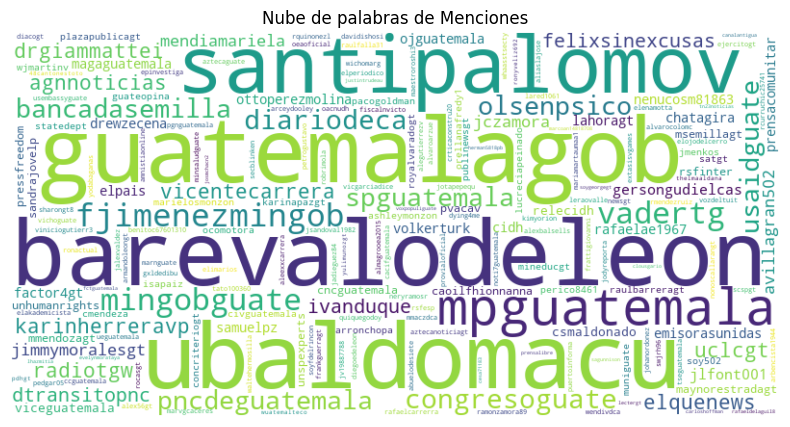

In [9]:
# Unir todas las menciones en un solo string
mentions_string = ' '.join(all_mentions.index)

# Generar la nube de palabras
wordcloud_mentions = WordCloud(width=800, height=400, background_color='white').generate(mentions_string)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mentions, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de Menciones')
plt.show()


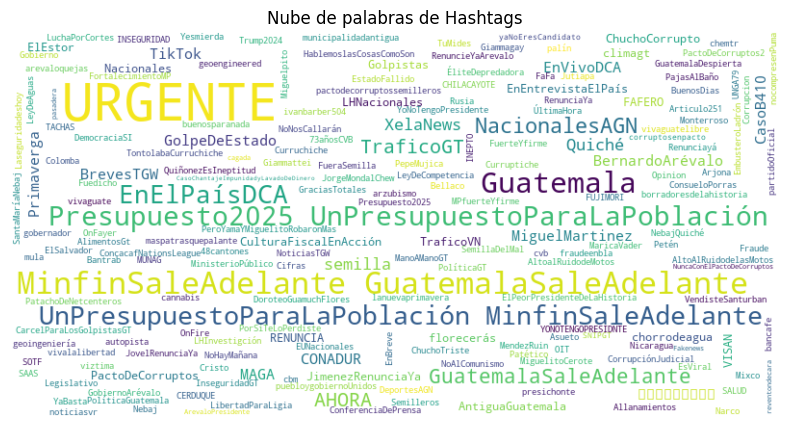

In [10]:
# Unir todos los hashtags en un solo string
hashtags_string = ' '.join(df['hashtags'].explode().dropna())

# Generar la nube de palabras
wordcloud_hashtags = WordCloud(width=800, height=400, background_color='white').generate(hashtags_string)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hashtags, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de Hashtags')
plt.show()

In [11]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir nodos y aristas desde el DataFrame
for index, row in edges_df.iterrows():
    G.add_edge(row['username'], row['target_user'])

# Contar la cantidad de interacciones para cada usuario (como source o target)
user_counts = pd.concat([edges_df['username'], edges_df['target_user']]).value_counts()

# Crear el grafo dirigido con nodos únicos
G = nx.DiGraph()

# Añadir nodos con el atributo 'size' basado en el número de interacciones
for user, count in user_counts.items():
    G.add_node(user, size=count)

# Añadir las aristas (interacciones entre los usuarios)
for index, row in edges_df.iterrows():
    G.add_edge(row['username'], row['target_user'])

labels = {user: user for user in G.nodes()}

# Extraer el tamaño de los nodos basado en el número de interacciones
node_sizes = [G.nodes[user]['size'] * 5 for user in G.nodes()]  # Multiplicamos para hacerlos más visibles

# Crear el primer filtro para eliminar nodos con menos de 5 relaciones
user_counts_filtered = user_counts[user_counts >= 5]  # Solo usuarios con 5 o más relaciones

# Crear un nuevo grafo dirigido con nodos filtrados
G_filtered = nx.DiGraph()

# Añadir nodos con el atributo 'size' solo para usuarios que tienen 5 o más relaciones
for user, count in user_counts_filtered.items():
    G_filtered.add_node(user, size=count)

# Añadir las aristas para las interacciones solo si ambos usuarios están en el conjunto filtrado
for index, row in edges_df.iterrows():
    if row['username'] in G_filtered and row['target_user'] in G_filtered:
        G_filtered.add_edge(row['username'], row['target_user'])

# Verificar la cantidad de nodos y aristas
print(f"Número de nodos (filtrado): {G_filtered.number_of_nodes()}")
print(f"Número de aristas (filtrado): {G_filtered.number_of_edges()}")

labels = {user: user for user in G_filtered.nodes()}

# Extraer los tamaños de los nodos
node_sizes_filtered = [G_filtered.nodes[user]['size'] * 5 for user in G_filtered.nodes()]


Número de nodos (filtrado): 1106
Número de aristas (filtrado): 7860


Número de nodos (filtrado): 1106
Número de aristas (filtrado): 7860


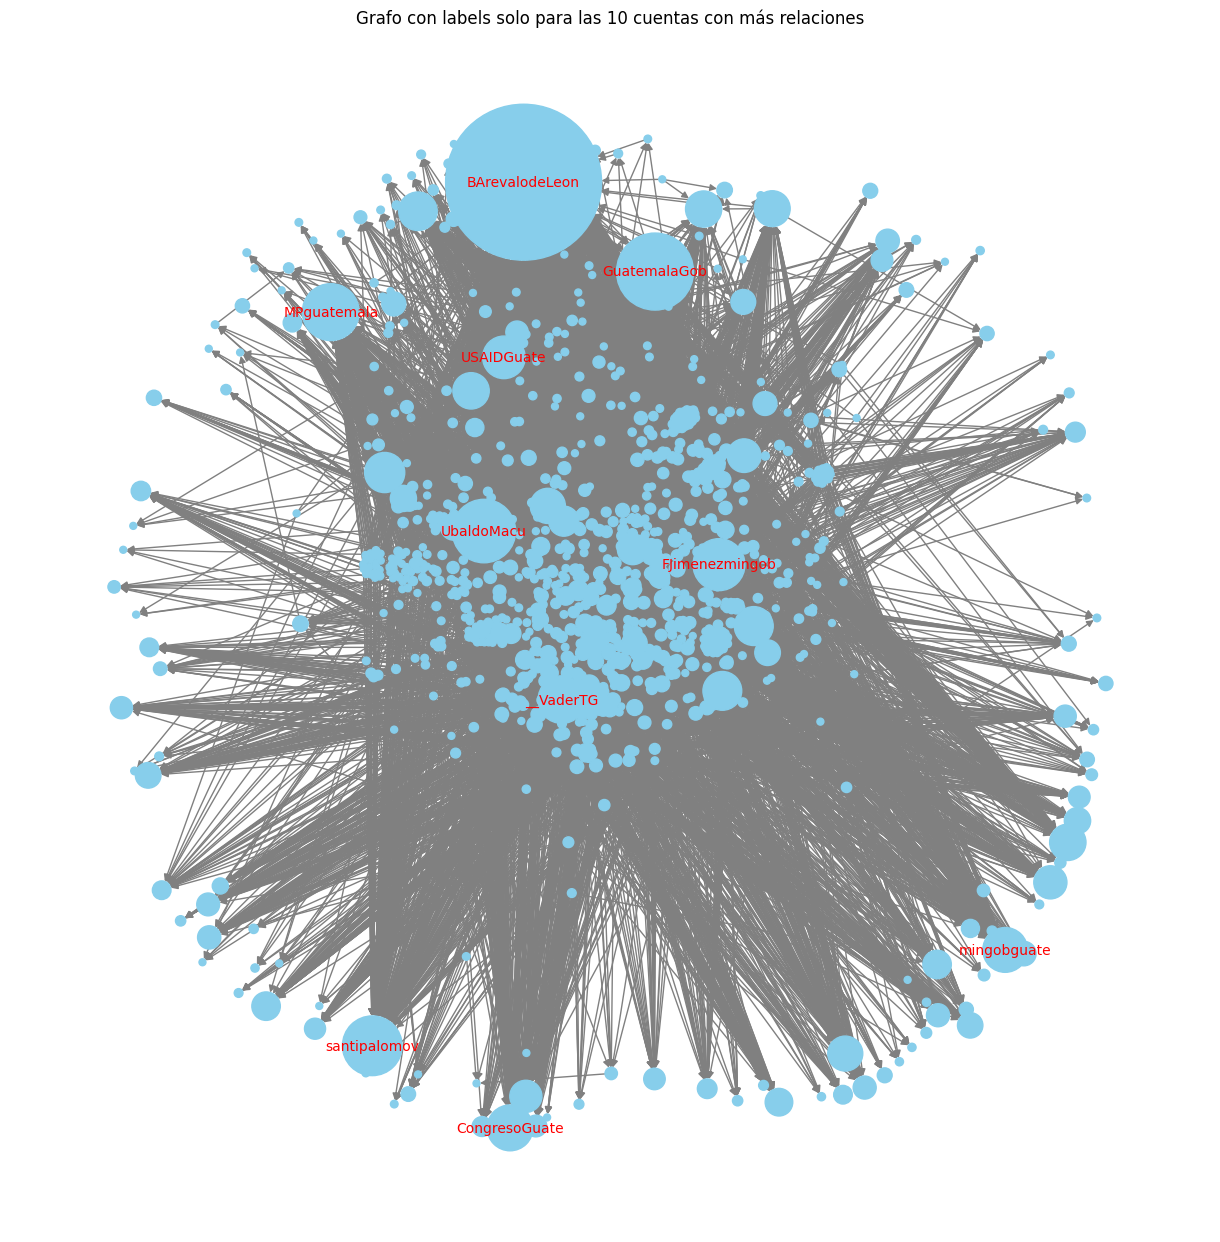

In [12]:
# Crear el primer filtro para eliminar nodos con menos de 5 relaciones
user_counts_filtered = user_counts[user_counts >= 5]  # Solo usuarios con 5 o más relaciones

# Crear un nuevo grafo dirigido con nodos filtrados
G_filtered = nx.DiGraph()

# Añadir nodos con el atributo 'size' solo para usuarios que tienen 5 o más relaciones
for user, count in user_counts_filtered.items():
    G_filtered.add_node(user, size=count)

# Añadir las aristas para las interacciones solo si ambos usuarios están en el conjunto filtrado
for index, row in edges_df.iterrows():
    if row['username'] in G_filtered and row['target_user'] in G_filtered:
        G_filtered.add_edge(row['username'], row['target_user'])

# Verificar la cantidad de nodos y aristas
print(f"Número de nodos (filtrado): {G_filtered.number_of_nodes()}")
print(f"Número de aristas (filtrado): {G_filtered.number_of_edges()}")

labels = {user: user for user in G_filtered.nodes()}

# Extraer los tamaños de los nodos
node_sizes_filtered = [G_filtered.nodes[user]['size'] * 5 for user in G_filtered.nodes()]

pos_filtered = nx.spring_layout(G_filtered, k=0.15)

# Obtener los 10 usuarios con más relaciones
top_10_users = user_counts_filtered.nlargest(10).index

# Dibujar el grafo con labels solo para los top 10
plt.figure(figsize=(12, 12))
nx.draw(G_filtered, pos_filtered, with_labels=False, node_size=node_sizes_filtered, node_color='skyblue', font_size=10, edge_color='gray')

# Añadir labels solo para los top 10
top_labels = {user: user for user in top_10_users}
nx.draw_networkx_labels(G_filtered, pos_filtered, labels=top_labels, font_size=10, font_color='red')

plt.title('Grafo con labels solo para las 10 cuentas con más relaciones')
plt.show()

In [13]:
# Convertimos el grafo dirigido a no dirigido, ya que Louvain requiere un grafo no dirigido
G_undirected = G.to_undirected()

# Aplicamos el algoritmo de Louvain para detectar las comunidades
partition = community_louvain.best_partition(G_undirected)

# Añadir la comunidad detectada como un atributo de los nodos
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id


In [14]:
# Centralidad de grado (in-degree para menciones recibidas, out-degree para menciones realizadas)
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Obtener los 10 usuarios con mayor centralidad de grado
top_10_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_in_degree = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_out_degree = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 usuarios por centralidad de grado:")
for user, centrality in top_10_degree:
    print(f"Usuario: {user}, Centralidad de grado: {centrality}")

Top 10 usuarios por centralidad de grado:
Usuario: BArevalodeLeon, Centralidad de grado: 0.8129635601418896
Usuario: GuatemalaGob, Centralidad de grado: 0.1983231215736859
Usuario: UbaldoMacu, Centralidad de grado: 0.1347952273460174
Usuario: santipalomov, Centralidad de grado: 0.11931634956465656
Usuario: MPguatemala, Centralidad de grado: 0.10835214446952596
Usuario: FJimenezmingob, Centralidad de grado: 0.09029345372460496
Usuario: __VaderTG, Centralidad de grado: 0.07578200580457917
Usuario: CongresoGuate, Centralidad de grado: 0.07029990325701387
Usuario: mingobguate, Centralidad de grado: 0.06707513705256368
Usuario: USAIDGuate, Centralidad de grado: 0.06062560464366333


In [15]:
# Centralidad de intermediación
betweenness_centrality = nx.betweenness_centrality(G)

# Obtener los 10 usuarios con mayor centralidad de intermediación
top_10_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 usuarios por centralidad de intermediación:")
for user, centrality in top_10_betweenness:
    print(f"Usuario: {user}, Centralidad de intermediación: {centrality}")


Top 10 usuarios por centralidad de intermediación:
Usuario: UbaldoMacu, Centralidad de intermediación: 0.013389541771575156
Usuario: BenitoC67601310, Centralidad de intermediación: 0.010981089421132106
Usuario: RafaelAE1967, Centralidad de intermediación: 0.005655238313194647
Usuario: __VaderTG, Centralidad de intermediación: 0.0047829166400412924
Usuario: AxelGar56163124, Centralidad de intermediación: 0.002456526832680207
Usuario: anti_chairosgt, Centralidad de intermediación: 0.002255546994156286
Usuario: RafaelDelAguil8, Centralidad de intermediación: 0.0014910523883331942
Usuario: arronchopa, Centralidad de intermediación: 0.001409630013805565
Usuario: MendiaMariela, Centralidad de intermediación: 0.001173410451673967
Usuario: wichomarg, Centralidad de intermediación: 0.0011273404153900558


In [ ]:
# Inicializar el modelo de análisis de sentimiento multilingüe
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Aplicar el modelo a cada tweet
df['sentimiento_bert'] = df['rawContent'].apply(lambda tweet: sentiment_analyzer(tweet)[0]['label'])

# Contar cuántos tweets caen en cada categoría de sentimiento
sentiment_counts_bert = df['sentimiento_bert'].value_counts()
print("Distribución del sentimiento en los tweets con BERT:")
print(sentiment_counts_bert)

# Mostrar algunos ejemplos de tweets por sentimiento
print("\nEjemplos de tweets positivos:")
print(df[df['sentimiento_bert'] == '5 stars'].head(3))

print("\nEjemplos de tweets negativos:")
print(df[df['sentimiento_bert'] == '1 star'].head(3))

# Contar cuántos tweets caen en cada categoría de sentimiento
sentiment_counts_bert = df['sentimiento_bert'].value_counts()

# Crear un gráfico de barras para visualizar la distribución del sentimiento
sentiment_counts_bert.plot(kind='bar', color=['red', 'green', 'orange', 'yellow', 'grey'], figsize=(8, 6))
plt.title('Distribución del Sentimiento (Modelo BERT)')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=0)
plt.show()